In [1]:
import os
import time
import json
import numpy as np
import pandas as pd
import threading

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

from mpl_finance import candlestick_ohlc
import mpl_finance as mplf

import tkinter as tk
from tkinter import *
from tkinter import ttk

import tensorflow as tf
from scipy.interpolate import interp1d
from scipy import signal

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


((array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ...

In [ ]:
#file_names = os.listdir("D:\\market_train\\dataset\\nifty 1m")


#or file in file_names[0:1]:\
file_name = "ACC_minute_data_with_indicators.csv"
csv_data = pd.read_csv("D:\\market_train\\dataset\\data creation\\"+file_name)
csv_data['date'] = pd.to_datetime(csv_data['date'])


In [2]:
file_names = os.listdir("D:\\market_train\\dataset\\data creation")
column_names = ["date","close","high","low","open","volume","patternName_doubletop","patternFeatures_doubletop","patternName_headandshoulders","patternFeatures_headandshoulders"]

csv_data_temp = pd.DataFrame(columns=column_names)

for file in file_names:
    print(file)
    file_data = pd.read_csv("D:\\market_train\\dataset\\data creation\\"+file)
    csv_data_temp = pd.concat([csv_data_temp[column_names], file_data[column_names]], axis=0,ignore_index=True)

csv_data = csv_data_temp

AAC.csv
ACC_minute_data_with_indicators.csv


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8036\1535944722.py:8: DtypeWarning: Columns (15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  file_data = pd.read_csv("D:\\market_train\\dataset\\data creation\\"+file)


ADANIENT_with_indicators_.csv
ADANIGREEN_with_indicators_.csv


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8036\1535944722.py:8: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  file_data = pd.read_csv("D:\\market_train\\dataset\\data creation\\"+file)


AMBUJACEM_with_indicators_.csv
APOLLOHOSP_with_indicators_.csv
ASIANPAINT_with_indicators_.csv


In [3]:
def normalize(data, window_limit):
    data = np.array(data,dtype=np.float32)

    max_value = max(data[0:window_limit])
    min_value = min(data[0:window_limit])
    if min_value != max_value:
        normalized_data = (data - min_value) / (max_value - min_value)

        min_value = min(normalized_data[0:window_limit])
        max_value = max(normalized_data[0:window_limit])

        normalized_data = (normalized_data - min_value) / (max_value - min_value)

        return normalized_data,True
    else:
        return False,False


def get_y_data_old(data):
    
    high_arr = []
    low_arr = []

    for value in data:
        if value > data[0]:
            value = value - data[0]
            high_arr.append(value)
        else:
            value = data[0] - value
            low_arr.append(value)
    
    high_mean = sum(high_arr)
    low_mean = sum(low_arr)

    if high_mean > low_mean:
        if low_mean/high_mean < 0.09:
            result = 1
        else:
            result = 0
    else:
        if high_mean/low_mean < 0.09:
            result = -1
        else:
            
            result = 0

    return result


def check_volatility(data):
    buffer = []
    volatality = None
    for value in range(len(data)-4):
        buffer = data[value : value+5]
        if buffer[0] == buffer[1] == buffer[2] == buffer[3] == buffer[4]:
            volatality = False
            break
        else:
            volatality = True
        buffer = []

    return volatality
        
        
def smoothening(arr,gamma):

    EMA = arr[0]
    temp = np.array(arr)
    for ti in range(len(arr)):
        EMA = gamma*temp[ti] + (1-gamma)*EMA
        temp[ti] = EMA
    return temp

def smoothening_2(arr):
    temp = np.array(arr)
    result = np.array(arr)
    arr_len = len(arr)-1
    for i in range(len(temp)):
        v = temp[i]
        val1,val2,val3,val4,val5,val6,val7,val8,val9,val10,val11,val12 = (v,v,v,v,v,v,v,v,v,v,v,v)

        if i-1 >= 0:
            val1 = temp[i-1]
        if i-2 >= 0:
            val2 = temp[i-2]
        if i-3 >= 0:
            val3 = temp[i-3]
        if i-4 >= 0:
            val4 = temp[i-4]
        if i-1 >= 0:
            val5 = temp[i-1]
        if i-2 >= 0:
            val6 = temp[i-2]
        
        if i+1 <= arr_len:
            val7 = temp[i+1]
        if i+2 <= arr_len:
            val8 = temp[i+2]
        if i+3 <= arr_len:
            val9 = temp[i+3]
        if i+4 <= arr_len:
            val10 = temp[i+4]
        if i+5 <= arr_len:
            val11 = temp[i+5]
        if i+6 <= arr_len:
            val12 = temp[i+6]


        result[i] = ((v+val1+val2+val3+val4+val5+val6+val7+val8+val9+val10+val11+val12)/13)
        #print(v,val1,val2,val3,val4,val5,val6,val7,val8,val9,val10,val11,val12)
    return result


def smoothening_3(arr):
    temp = np.array(arr)
    result = np.array(arr)
    arr_len = len(arr)-1
    for i in range(len(temp)):
        v = temp[i]
        val1,val2,val3,val4,val5,val6,val7,val8,val9,val10,val11,val12 = (v,v,v,v,v,v,v,v,v,v,v,v)

        if i-1 >= 0:
            val1 = temp[i-1]
        if i-2 >= 0:
            val2 = temp[i-2]
        if i-3 >= 0:
            val3 = temp[i-3]
        
        if i+1 <= arr_len:
            val7 = temp[i+1]
        if i+2 <= arr_len:
            val8 = temp[i+2]
        if i+3 <= arr_len:
            val9 = temp[i+3]

        result[i] = ((v+val1+val2+val3+val7+val8+val9)/7)
        #print(v,val1,val2,val3,val4,val5,val6,val7,val8,val9,val10,val11,val12)
    return result


def low_pass_filter(data):

    sampling_frequency = 1.0    
    nyquist_frequency = 0.5 * sampling_frequency
    cutoff_frequency = 0.4
    order = int(len(data)/6)+1
    #print(order)
    try:
        b, a = signal.butter(order, cutoff_frequency, btype='low')
        filtered_data = signal.filtfilt(b, a, data)
    except:
        return False,False
    return filtered_data,True



def interpolate_sequence(data, target_size):
    if target_size <= len(data):
        pass
        #return data

    x = np.arange(len(data))
    f = interp1d(x, data, kind='cubic')
    new_x = np.linspace(0, len(data) - 1, target_size)
    interpolated_data = f(new_x)
    
    return interpolated_data.tolist()

def invert_sequence(data):
    data = np.array(data)
    max_value = max(data)
    inverted_data = [max_value - x for x in data]+max_value
    return inverted_data - 1


In [ ]:
x_data_DT = []
y_data_DT = []
raw_data_DT = []
pattern_features_DT_sample = ['START','TOP 1','NECKLINE','TOP 2','TARGET']
pattern_features_DT = []
pattern_features_counter = 0
counter = 0
close = csv_data['close']


while True:
    if csv_data['patternName_doubletop'][counter] == 'DT':
        raw_data_temp = []
        pattern_features_DT_temp = []
        pattern_features_values = []
        pattern_features_counter = 0
        invert_needed = False
        filter_status = False
        try:
            for i in range(counter,len(close)):

                if csv_data['patternName_doubletop'][i] == 'DT':
                    raw_data_temp.append(close[i])

                    if pattern_features_DT_sample[pattern_features_counter] == csv_data['patternFeatures_doubletop'][i]:
                        pattern_features_DT_temp.append(i)
                        pattern_features_values.append(close[i])
                        pattern_features_counter += 1
                        
                            

                else:
                    counter = i
                    break
            if pattern_features_values[3] < pattern_features_values[4]:
                print(pattern_features_values)
                invert_needed = True 


            pattern_features_DT_temp = np.array(pattern_features_DT_temp)
            pattern_features_DT_temp = pattern_features_DT_temp - pattern_features_DT_temp[0]
            pattern_features_DT_temp = pattern_features_DT_temp / pattern_features_DT_temp[4] * 100
        
        
        except:
            print("error on DT",counter)
        
        smoothened_data,filter_status = low_pass_filter(raw_data_temp)
        if filter_status and len(pattern_features_DT_temp) == 5:
            
            interpolated_data = interpolate_sequence(smoothened_data,100)
            interpolated_data,filter_status = low_pass_filter(interpolated_data)
            normalized_data, normalized_status = normalize(interpolated_data,len(interpolated_data))
            if invert_needed:
                normalized_data = invert_sequence(normalized_data)
            x_data_DT.append(normalized_data)
            pattern_features_DT.append(pattern_features_DT_temp)
            raw_data_DT.append(raw_data_temp)

    counter += 1
    if counter >= len(close):
        break
        
x_data_HS = []
y_data_HS = []
raw_data_HS = []
pattern_features_HS_sample = ['START','SHOULDER 1','NECKLINE 1','HEAD','NECKLINE 2','SHOULDER 2','TARGET']
pattern_features_HS = []
counter = 0

while True:
    if csv_data['patternName_headandshoulders'][counter] == 'H&S':
        raw_data_temp = []
        pattern_features_HS_temp = []
        pattern_features_values = []
        pattern_features_counter = 0
        filter_status = False
        invert_needed = False
        try:
            for i in range(counter,len(close)):

                if csv_data['patternName_headandshoulders'][i] == 'H&S':
                    raw_data_temp.append(close[i])

                    if pattern_features_HS_sample[pattern_features_counter] == csv_data['patternFeatures_headandshoulders'][i]:
                        pattern_features_HS_temp.append(i)
                        pattern_features_values.append(close[i])
                        pattern_features_counter += 1
                            
                else:
                    counter = i
                    break
            if pattern_features_values[3] < pattern_features_values[6]:
                print(pattern_features_values)
                invert_needed = True 

            smoothened_data,filter_status = low_pass_filter(raw_data_temp)

            
            pattern_features_HS_temp = np.array(pattern_features_HS_temp)
            pattern_features_HS_temp = pattern_features_HS_temp - pattern_features_HS_temp[0]
            pattern_features_HS_temp = pattern_features_HS_temp / pattern_features_HS_temp[6] * 100
        

        except:
            print("error on H&S",counter)

        if filter_status:
            interpolated_data = interpolate_sequence(smoothened_data,100)
            interpolated_data,filter_status = low_pass_filter(interpolated_data)
            normalized_data, normalized_status = normalize(interpolated_data,len(interpolated_data))
            if invert_needed:
                normalized_data = invert_sequence(normalized_data)
            x_data_HS.append(normalized_data)
            pattern_features_HS.append(pattern_features_HS_temp)
            raw_data_HS.append(raw_data_temp)

    counter += 1
    if counter >= len(close):
        break


x_train = []
x_train.extend(x_data_HS)
x_train.extend(x_data_DT)

x_train = np.array(x_train,dtype=np.float32)

In [4]:

def append_tot_data(x_data,raw_data,pattern_type,pattern_features,y_data,start_index,end_index):
    tot_data_temp = {}
    
    tot_data_temp["x_data"] = x_data
    tot_data_temp["raw_data"] = raw_data
    tot_data_temp["pattern_type"] = pattern_type
    tot_data_temp["pattern_features"] = pattern_features
    tot_data_temp["y_data"] = y_data
    tot_data_temp["start_index"] = start_index
    tot_data_temp["end_index"] = end_index
    
    tot_data.append(tot_data_temp)

def get_features_data(data,start_index,end_index,pattern_features_sample,pattern_start_index,pattern_end_index):
    pattern_features_temp = []
    pattern_features_counter = 0
    try:
        for i in range(start_index,end_index):
            if pattern_features_counter < len(pattern_features_sample):
                if pattern_features_DT_sample[pattern_features_counter] == csv_data['patternFeatures_doubletop'][i] and i >= pattern_start_index:
                    pattern_features_temp.append(i)
                    pattern_features_counter += 1

                    
        #print(pattern_features_temp)


        pattern_features_temp = np.array(pattern_features_temp)
        pattern_features_temp = pattern_features_temp - start_index
        pattern_features_temp = pattern_features_temp / (end_index - start_index) * 100

        if len(pattern_features_temp) != 5:raise IndexError
    except IndexError:
        return 0,0
    return pattern_features_temp,1

def get_y_data(data,start_index,end_index,pattern_start_index,pattern_end_index):

    #start = int((pattern_start_index - start_index) / len(data) * 100)
    #end = int((pattern_end_index - start_index) / len(data) * 100)
    difference = pattern_end_index - pattern_start_index
    start = int(pattern_start_index - difference * 0.2)
    end = int(pattern_end_index + difference * 0.2)
    print("start y_data = ",start,"end y_data = ",end)
    print("start",start_index,"end",end_index,"pattern start",pattern_start_index,"pattern end",pattern_end_index)

    y_data = np.zeros(100,dtype=np.float32)
    y_data[start : end+1] = 1
    



    return y_data

def process_x_data(data):
    filter_status = True
    normalized_status = False
    try:
        data = interpolate_sequence(data,100)
        #data, filter_status = low_pass_filter(data)
        data, normalized_status = normalize(data, len(data))
    
    except:
        print("data = ",data)
        return 0,0 
    
    if filter_status and normalized_status:
        return data, 1
    else:
        return 0,0






tot_data = []


In [5]:
tot_data = []
pattern_features_DT_sample = ['START','TOP 1','NECKLINE','TOP 2','TARGET']
pattern_features_HS_sample = ['START','SHOULDER 1','NECKLINE 1','HEAD','NECKLINE 2','SHOULDER 2','TARGET']
counter = 0
close = csv_data['close']



while True:
    
    if csv_data['patternName_doubletop'][counter] == 'DT':
        raw_data = []
        pattern_features_DT = []
        pattern_features_values = []
        start_counter = counter
        pattern_features_counter = 0


        for i in range(start_counter,len(close)):
            if csv_data['patternName_doubletop'][i] == 'DT':
                counter += 1
            else:
                break

        pattern_length = counter - start_counter
        start_index = np.random.randint(start_counter - pattern_length * 2.5 ,start_counter)
        end_index = np.random.randint(counter,counter + pattern_length * 2.5)
        #print("start = ",start_index,"end = ",end_index)
        #print("start_counter",start_counter,"pattern length", pattern_length,"counter = ",counter)

        for i in range(start_index,end_index):
            raw_data.append(close[i])

        pattern_features_DT, features_status = get_features_data(data=raw_data, start_index=start_index, end_index=end_index, pattern_features_sample=pattern_features_DT_sample,pattern_start_index=start_counter,pattern_end_index=start_counter+pattern_length)
        
        x_data, x_data_status = process_x_data(raw_data)
        
        if features_status and x_data_status:
            y_data = get_y_data(data = raw_data,start_index = start_index,end_index = end_index,pattern_start_index = pattern_features_DT[1],pattern_end_index = pattern_features_DT[3])
            append_tot_data(raw_data=raw_data, x_data = x_data, y_data= y_data, pattern_type= 'DT',pattern_features= pattern_features_DT,start_index=start_counter,end_index=counter)
        else:
            print("error on ",counter)
    counter += 1
    if counter >= len(close):
        break
        



start y_data =  66 end y_data =  75
start 136 end 179 pattern start 67.44186046511628 pattern end 74.4186046511628
start y_data =  41 end y_data =  46
start 615 end 702 pattern start 42.5287356321839 pattern end 45.97701149425287
start y_data =  43 end y_data =  57
start 501 end 965 pattern start 45.9051724137931 pattern end 55.81896551724138
start y_data =  19 end y_data =  36
start 1035 end 1109 pattern start 21.62162162162162 pattern end 33.78378378378378
start y_data =  33 end y_data =  40
start 976 end 1359 pattern start 34.46475195822455 pattern end 39.1644908616188
start y_data =  28 end y_data =  50
start 1237 end 1325 pattern start 31.818181818181817 pattern end 47.72727272727273
start y_data =  47 end y_data =  52
start 1252 end 1561 pattern start 48.54368932038835 pattern end 51.45631067961165
start y_data =  33 end y_data =  63
start 1493 end 1525 pattern start 37.5 pattern end 59.375
start y_data =  48 end y_data =  58
start 1743 end 1837 pattern start 50.0 pattern end 57.

In [ ]:
tot_data[1]

In [ ]:
fig,ax = plt.subplots(20, figsize = (8,60))
for i in range(20):
    #ax[i].plot(range(len(tot_data[i]['raw_data'])),normalize( tot_data[i]['raw_data'],len(tot_data[i]['raw_data']))[0])
    ax[i].bar(tot_data[i]['pattern_features'],[1,1,1,1,1],color = 'green')
    ax[i].plot(range(len(tot_data[i]['x_data'])),normalize( tot_data[i]['x_data'],len(tot_data[i]['x_data']))[0])
    ax[i].bar(range(100),tot_data[i]['y_data']/60,color = 'blue')
    #raw_data = normalize(interpolate_sequence(tot_data[i]['raw_data'],100),100)[0]
    #ax[i].plot(range(len(raw_data)),raw_data)

In [ ]:
fig,ax = plt.subplots(60, figsize = (8,200))
for i in range(60):
    #ax[i].plot(range(len(tot_data[i]['x_data'])),tot_data[i]['x_data'],color = "blue")
    ax[i].bar(range(100),y_train[i],color = 'green')
    ax[i].plot(range(len(x_train[i])),x_train[i])

In [6]:
x_data = []
y_data = []

for data in tot_data:
    x_data.append(data['x_data'])
    y_data.append(data['y_data'])

x_data = np.array(x_data,dtype=np.float32)
y_data = np.array(y_data,dtype=np.float32)

In [ ]:
x_data = []
y_data = []

for data in tot_data:
    x_data.append(data['x_data'])

    y_temp = np.zeros(100,dtype=np.int16)

    for i in data['pattern_features']:
        y_temp[int(i)] = 1


    y_data.append(y_temp)

x_data = np.array(x_data,dtype=np.float32)
y_data = np.array(y_data,dtype=np.float32)

In [ ]:
y_data_DT = np.zeros(len(x_data_DT),dtype=np.float32)
y_data_HS = np.ones(len(x_data_HS),dtype=np.float32)

y_train = []

y_train.extend(y_data_HS)
y_train.extend(y_data_DT)
y_train = np.array(y_train,dtype=np.float32)

In [ ]:
y_train[0]

In [7]:
x_train,x_test , y_train,y_test = train_test_split(x_data,y_data,test_size=0.1,random_state=4)

In [ ]:
fig,ax = plt.subplots(10, figsize = (8,40))
temp = 100
for i in range(temp,temp+10):
    ax[i-temp].plot(range(len(x_train[i])),x_train[i])
    ax[i-temp].bar(range(100),y_train[i]/10)

In [16]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units = 100,input_shape = (100,1),return_sequences=True))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.LSTM(units = 200,return_sequences=True))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.LSTM(100))


optimiser = tf.keras.optimizers.Adam(0.001)
model.compile(loss='mean_squared_error',optimizer=optimiser,metrics=['mean_absolute_error','accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 200)          240800    
                                                                 
 dropout_1 (Dropout)         (None, 100, 200)          0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               120400    
                                                                 
Total params: 402,000
Trainable params: 402,000
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def create_lstm_model(input_shape=(100, 1)):
    model = tf.keras.models.Sequential()

    # LSTM layer with dropout for input sequence
    model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(tf.keras.layers.Dropout(0.2))

    # LSTM layer with dropout
    model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2))

    # LSTM layer with dropout
    model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2))

    # LSTM layer without return_sequences for the final prediction
    model.add(tf.keras.layers.LSTM(units=50))
    model.add(tf.keras.layers.Dropout(0.2))

    # Output layer
    model.add(tf.keras.layers.Dense(units=100))

    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_absolute_error','accuracy'])

    return model

# Create the model
model = create_lstm_model()

In [17]:
model.fit(x_train,y_train,epochs=1000,batch_size=32,verbose=1)

Epoch 1/1000
21/21 [==============================] - 15s 34ms/step - loss: 0.1352 - mean_absolute_error: 0.2339 - accuracy: 0.0108
Epoch 2/1000
21/21 [==============================] - 1s 26ms/step - loss: 0.1250 - mean_absolute_error: 0.2487 - accuracy: 0.0262
Epoch 3/1000
21/21 [==============================] - 1s 25ms/step - loss: 0.1246 - mean_absolute_error: 0.2462 - accuracy: 0.0246
Epoch 4/1000
21/21 [==============================] - 1s 26ms/step - loss: 0.1247 - mean_absolute_error: 0.2490 - accuracy: 0.0262
Epoch 5/1000
21/21 [==============================] - 1s 25ms/step - loss: 0.1242 - mean_absolute_error: 0.2471 - accuracy: 0.0246
Epoch 6/1000
21/21 [==============================] - 1s 26ms/step - loss: 0.1241 - mean_absolute_error: 0.2473 - accuracy: 0.0415
Epoch 7/1000
21/21 [==============================] - 1s 25ms/step - loss: 0.1241 - mean_absolute_error: 0.2468 - accuracy: 0.0262
Epoch 8/1000
21/21 [==============================] - 1s 26ms/step - loss: 0.1242 

In [9]:
model = tf.keras.models.load_model("D:\\market_train\\models\\double_top.h5")

In [10]:
pred = model.predict([x_test[0].reshape(1,100)])

1/1 [==============================] - 2s 2s/step


In [12]:
print(x_test[0].reshape(1,100).shape)
print(x_test.shape)
print(pred.shape)
print(pred)

(1, 100)
(73, 100)
(1, 100)
[[ 2.54904489e-06 -2.27840021e-04 -2.37535598e-04  3.48338399e-05
  -1.16882475e-05 -1.26338846e-05 -6.76268246e-06  2.27067103e-05
  -3.68534093e-05 -1.59232679e-03 -7.72801088e-03  6.86823716e-03
   1.80426419e-01  9.43682194e-02  2.86145747e-01  2.89207071e-01
   2.86979645e-01  8.28968823e-01  9.72497523e-01  9.47847605e-01
   9.87908959e-01  9.91168499e-01  9.65764523e-01  9.84168828e-01
   9.93952394e-01  9.86707151e-01  9.98324096e-01  9.83676136e-01
   9.98651326e-01  9.97809947e-01  9.97196615e-01  7.55369663e-03
   7.01779574e-02  8.38081956e-01  6.11449957e-01  6.03501379e-01
  -1.49780558e-02  2.34738900e-03  1.15937775e-03 -5.12180326e-04
  -2.83399684e-04 -2.06750392e-05 -5.80194392e-05 -1.16102106e-04
  -1.21397803e-04 -3.92481525e-05 -2.30396768e-06 -5.01016939e-06
  -3.42095955e-05  1.98797097e-05  9.27659930e-05  1.51301936e-06
  -1.00152920e-06 -5.86246642e-05 -3.97000849e-06  2.64695495e-06
  -1.13307273e-04  3.99049651e-03  1.08896568e-0

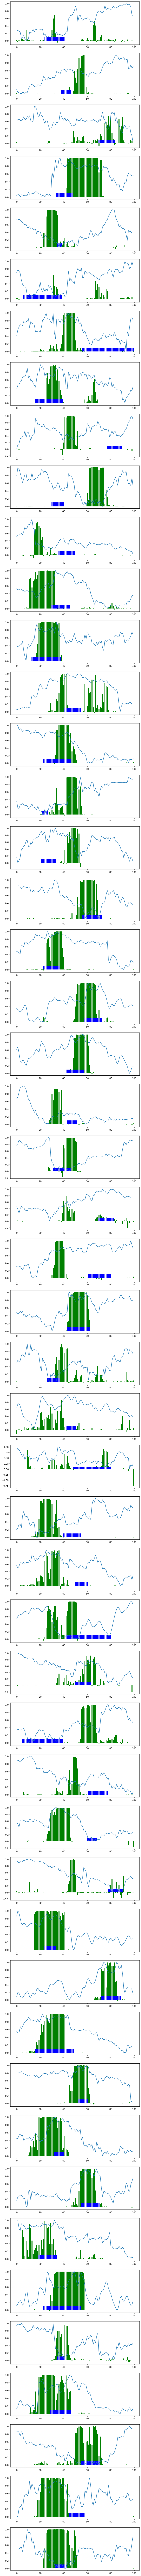

In [10]:
fig,ax = plt.subplots(50,figsize = (10,200))

for i in range(50):
    data = x_test[i]
    
    ax[i].bar(range(100),pred[i],color = "green")
    ax[i].bar(range(100),y_test[i]/10,color = "blue")

    ax[i].plot(range(len(data)),data)
    #ax[i].bar(105,pred[i][1],color = "green")




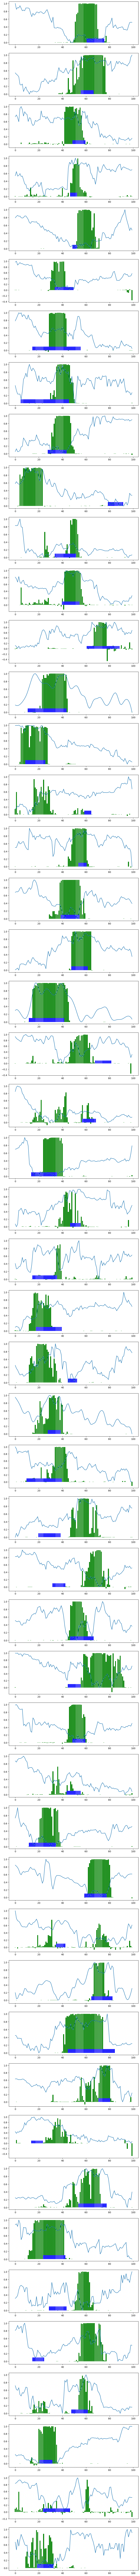

In [19]:
fig,ax = plt.subplots(50,figsize = (10,200))

for i in range(50):
    data = x_test[i]
    
    ax[i].bar(range(100),pred[i],color = "green")
    ax[i].bar(range(100),y_test[i]/10,color = "blue")

    ax[i].plot(range(len(data)),data)
    #ax[i].bar(105,pred[i][1],color = "green")




In [ ]:
fig,ax = plt.subplots(50,figsize = (10,200))

for i in range(50):
    data = x_test[i]
    
    ax[i].bar(range(100),pred[i],color = "green")
    ax[i].bar(range(100),y_test[i]/10,color = "blue")

    ax[i].plot(range(len(data)),data)
    #ax[i].bar(105,pred[i][1],color = "green")




In [ ]:
model.save("D:\\market_train\\models\\double_top.h5")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

data = raw_data_HS[4]

time = np.arange(len(data))
cutoff_frequency = 0.3  # Adjust this value as needed
order = 40  # The filter order

b, a = signal.butter(order, cutoff_frequency, btype='low')

filtered_data = signal.filtfilt(b, a, data)
smoothened_data = smoothening_3(data)

plt.figure(figsize=(10, 6))
plt.plot(time, data, 'b-',linewidth = 2, label='Original Data')
plt.plot(time, filtered_data, 'r-', linewidth=2, label='Filtered Data')
plt.plot(time, smoothened_data, 'g-', linewidth=2, label='smoothened Data')

plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Low-Pass Butterworth Filter')
plt.grid(True)
plt.show()


In [ ]:
x = [1,2,3,4]
y = [i for i in x]
print(y)

In [ ]:
data = raw_data_DT[8]
fig,ax = plt.subplots(50,figsize = (10,200))

for i in range(50):
    data = raw_data_DT[i]

    data_t,status = low_pass_filter(data)
    if status:
        ax[i].plot(range(len(data_t)),data_t)
        ax[i].plot(range(len(data_t)),data)



In [ ]:
fig,ax = plt.subplots(10, figsize = (8,40))
for i in range(700,710):
    ax[i-700].plot(range(len(x_train[i])),x_train[i])
    

In [ ]:
x_train[0]

In [ ]:
x = np.array(list(range(0,10)))
y = np.array(list(range(0,20,2)))


model = tf.keras.Sequential([tf.keras.layers.Dense(units = 1,input_shape = (1,))])
optimiser = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimiser, loss = 'mean_squared_error',metrics=['accuracy'])





model.summary()

In [ ]:
model.fit(x,y,epochs=1000,batch_size=32)

In [ ]:
model.predict([500])

In [54]:

def analyze_output(output, min_threshold = 0.5, min_no_of_max = 8):
    
    no_of_maxes = 0
    output_pass = 0
    start = 0
    end = 0
    print(output)
    for index,value in enumerate(output):

        if no_of_maxes >= min_no_of_max:
            output_pass = 1

        if value >= 0.9:
            no_of_maxes += 1
        else:
            if no_of_maxes < min_no_of_max:
                no_of_maxes = 0
            elif no_of_maxes >= min_no_of_max:
                end = index 
                start = index - no_of_maxes 
                break

    return output_pass,start,end






sample_output = [0.0, 0.01 ,0.0 ,0.0 ,0.0 ,0.2 ,0.05 ,0.1 ,0.4 ,0.7 ,1.0 ,1.0 ,0.5 ,1.0 ,0.5 ,0.3 ,0.1 ,0.0 ,0.0 ,0.0 ,0.01]



In [70]:

analyze_output(output=pred[14])

[-4.01555837e-07 -8.96055099e-06  1.89470738e-04  8.66834944e-06
 -8.48786876e-05  8.22081638e-04  1.33782392e-04  2.29612651e-05
  2.76279878e-02 -4.99406422e-04 -3.59476471e-05  1.91414182e-03
  9.56561789e-02  1.48655564e-01  1.71627268e-01  5.27863026e-01
  6.52618170e-01  6.87271833e-01  6.38436854e-01  6.94958210e-01
  9.18006063e-01  9.25707102e-01  7.79245079e-01  8.95421445e-01
  5.50686181e-01  8.99154544e-01  9.47834432e-01  7.97058344e-01
  7.66404569e-01  5.89435041e-01  1.14411645e-01  9.94213641e-01
  9.98512328e-01  9.98290539e-01  9.99167860e-01  9.96449351e-01
  9.81828034e-01  9.92588997e-01  9.89725888e-01  9.79539275e-01
  9.98756826e-01  9.15306330e-01  9.88079786e-01  9.91979122e-01
  7.34015286e-01  3.58310282e-01  6.52455688e-02  3.91195645e-04
  1.61670009e-03  6.62791426e-04  5.02665498e-05 -3.21627303e-05
 -1.10460707e-04 -1.38833711e-04  2.66409339e-03  6.40340208e-04
  2.02819263e-03  6.89637614e-04  9.99710523e-04 -8.11269856e-05
 -6.49566864e-05 -1.06568

(1, 31, 44)

In [73]:
pred[6]

array([ 6.23308413e-04, -7.25250342e-04,  3.26564885e-04, -2.42992508e-04,
       -6.29853318e-03,  1.17306173e-01,  4.98410046e-01,  3.46047014e-01,
        1.34132072e-01,  1.50937960e-01,  1.70501217e-01,  5.36466353e-02,
        8.34750291e-03, -1.33017190e-02,  1.09560139e-01,  1.14808694e-01,
        1.39061827e-02, -1.79565325e-03, -5.78240165e-03, -1.38413708e-03,
       -4.97665908e-03, -5.02593757e-04,  6.83882907e-02,  9.97530483e-03,
        2.21178052e-03, -4.06595431e-02,  5.01638830e-01,  5.00166774e-01,
       -2.16734651e-02,  1.20235376e-01,  1.62770346e-01,  4.74167196e-03,
       -1.46302709e-03,  2.49279867e-04, -8.70493823e-04, -1.04098028e-04,
       -1.16594566e-03, -1.78244861e-03,  1.94679536e-02,  1.21876737e-03,
       -1.32559962e-03,  2.67633740e-02,  5.69545478e-02,  2.96801645e-02,
        4.90259118e-02,  6.05436824e-02,  1.20612176e-03,  3.26136453e-03,
       -8.21858994e-04,  2.28436962e-01, -9.96080413e-03,  6.51320294e-02,
        7.41511524e-01,  

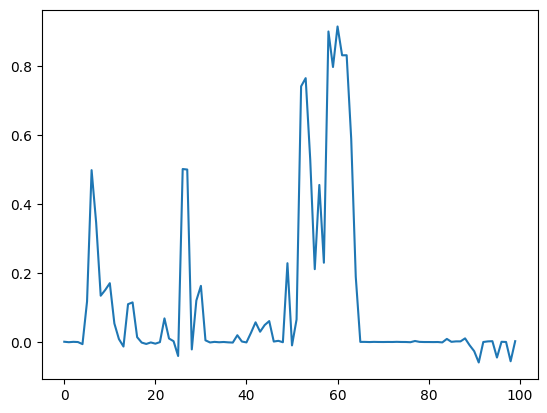

In [74]:
plt.plot(range(len(pred[6])),pred[6])